# Word Embeddings

<p style="color: yellow">
It is highly recommended to use google colab for this notebook or else you need to download a dataset of size 386Mb and place it beside your local notebook. Also the last section benefits from GPU.</p>

Welcome to the second notebook of this assignment! Word embeddings are numerical representations of words. We can represent words as vectors and maintain their meaning. There are various ways of finding vecotrs for words, equivalently, word embeddings. We explore some of these techniques in this notebook.

In [ ]:
name = "Parsa_Malekian"
student_id = 402171075
print(name, student_id)

Parsa_Malekian 402171075


## Tabel of Contents

- 1- GloVe: Global Vectors for Word Representation
  - 1.1- Exploring word vectors (5 p)
  - 1.2- Visualizing in 2-D (10 p)
- 2- Evaluation
  - 2.1- Cosine similarity (5 p)
  - 2.2- A little test set (10 p)
- 3- Learn embeddings
  - 3.1- Dataset Preprocessing (10 p)
  - 3.1- Tokenization and Phrase Detection (5 p)
  - 3.3- Co-occurrence Matrix (15 p)
  - 3.4- SVD (5 p)
  - 3.5- Similarity (20 p)
- 4- Sentiment Analysis of MDB Movie Reviews
  - 4.1- Dataset (5 p)
  - 4.2- Model (10 p)
  - 4.3- Train (10 p)

## 1- GloVe: Global Vectors for Word Representation

GloVe (Global Vectors for Word Representation) is a pre-trained word embedding model developed by Stanford University. It is trained on large text corpora such as Wikipedia and Gigaword. The embeddings capture the semantic meaning of words, so words with similar meanings are represented by similar vectors in the embedding space.

The specific file `glove.6B.300d.txt` contains word vectors of size 300 (300-dimensional embeddings) trained on a dataset of 6 billion tokens from Wikipedia and Gigaword.

The vocabulary refers to the set of all words (or tokens) in the dataset for which embeddings are provided. Each word is represented as a dense vector of real numbers.

### 1.1- Exploring word vectors

According to the semantic meanings, what would be the values of $x, y, z, u, v$ and why?

|         | man   | woman | king  | queen | apple | orange |
| ---     | ---   | ---   |   --- | ---   | ---   |  ---   |
| gender  | -0.99 | 1     | -0.95 | 0.97  | u     | 0.01   |
| royalty | 0.01  | 0.02  | 0.93  | 0.95  | -0.01 | 0.00   |
| fruit   | 0.03  | x     | y     | z     | 0.94  | v      |

Note that we want the embeddings to capture semantic meanings such that $$man - woman \approx king - queen$$.

> YOUR ANSWER (0 or 1)

- x ≈ 0
- y ≈ 0
- z ≈ 0
- v ≈ 1
- u ≈ 0

In [ ]:
# run this code to install gensim on your environment
!pip install gensim

You can use the cell bellow to mount your drive with google colab. then after adding the dataset to your drive, you can access the dataset through colab. pay attention to unzip the dataset first.

link to dataset: https://drive.google.com/file/d/1amUx0ErSa3hsqiCdOQyDkO8uQBWz0uqD/view?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

In [14]:
# unzip the dataset. you may need to modify the relative address based on the location of dataset in your drive.
!unzip drive/MyDrive/Colab\ Notebooks/glove.6B.300d.txt.zip

Archive:  drive/MyDrive/Colab Notebooks/glove.6B.300d.txt.zip
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


In [15]:
model_path = "glove.6B.300d.txt"
print("Loading GloVe model from local file...")
model = KeyedVectors.load_word2vec_format(model_path, binary=False, no_header=True)
print("Model loaded!")

Loading GloVe model from local file...
Model loaded!


- **Vocabulary Size:** The size of the vocabulary is the number of unique words in the dataset.
- **Embedding Dimension:** This represents the length of the vector used to encode each word. For `glove.6B.300d.txt`, the dimension is 300.

Here are the key attributes of the loaded model.

- `index_to_key`
  - **Description:** A list of all the words (tokens) in the vocabulary in the order they were loaded.
  - **Example Usage:** To access the 10th word in the vocabulary:
      ```python
    model.index_to_key[9]

- `key_to_index`
  - **Description**: A dictionary mapping each word (token) to its corresponding index in the vocabulary.
  - **Example Usage**: To get the index of the word "king":
      ```python
      model.key_to_index["king"]
- `vectors`
  - **Description**: A NumPy array of shape (vocab_size, embedding_dim) where each row corresponds to the embedding of a word in the vocabulary.
  - **Example Usage**: To access the vector for the word "queen":
      ```python
      model["queen"]

- `get_vector(word)`
  - **Description**: A method to retrieve the embedding vector for a specific word.
  - **Example Usage:**
      ```python
      embedding_vector = model.get_vector("apple")

In [16]:
def print_model_attributes(model):
    vocab_size = len(model.index_to_key)
    embedding_dim = model.vector_size
    return vocab_size, embedding_dim

vocab_size, embedding_dim = print_model_attributes(model)
print(f"Vocab size: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")

Vocab size: 400000
Embedding dimension: 300


### 1.2- Visualizing in 2-D

Use PCA and t-SNE for dimensionality reduction in [sklearn](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html) for visualizing the embeddings for relationships like:

- tall $\rightarrow$ taller $\rightarrow$ tallest
- big $\rightarrow$ bigger $\rightarrow$ biggest

In [17]:
def plot_embeddings_2d(model, words, method="PCA", perplexity=None, line_plot=None):
    # Convert method name to a standard format by removing special characters
    method = ''.join(char.lower() for char in method if char.isalnum())

    # TODO: reduce the dimensionality of the embeddings to 2D using PCA or t-SNE. (≈6 lines)
    # Create word embeddings matrix
    embeddings = np.vstack([model.get_vector(word) for word in words])

    # Apply dimensionality reduction based on selected method
    if method == "pca":
        reducer = PCA(n_components=2)
        reduced_embeddings = reducer.fit_transform(embeddings)
    elif method == "tsne":
        default_perplexity = 30
        reducer = TSNE(
            n_components=2,
            perplexity=perplexity if perplexity is not None else default_perplexity,
            random_state=42
        )
        reduced_embeddings = reducer.fit_transform(embeddings)
    else:
        raise ValueError("Unsupported reduction method. Please use either 'PCA' or 't-SNE'.")
    # plot
    plt.figure(figsize=(5, 5))
    for i, word in enumerate(words):
        x, y = reduced_embeddings[i]
        plt.scatter(x, y)
        plt.text(x + 0.01, y + 0.01, word, fontsize=12)

    if line_plot:
        for (i, j) in line_plot:
            x1, y1 = reduced_embeddings[i]
            x2, y2 = reduced_embeddings[j]
            plt.plot([x1, x2], [y1, y2], color='red', linestyle='--')

    plt.title(f"Word Embeddings Visualization ({method})")
    plt.show()

In [18]:
words = ["tall", "taller", "tallest", "big", "bigger", "biggest", "wide", "wider", "widest"]
line_plot = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8)]
words1 = ["smart", "smarter", "smartest", "wide", "wider", "widest", "small", "smaller", "smallest"]
line_plot1 = [(0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8)]
words2 = ["man", "woman", "king", "queen", "boy", "girl", "husband", "wife"]
line_plot2 = [(0, 1), (2, 3), (4, 5), (6, 7)]

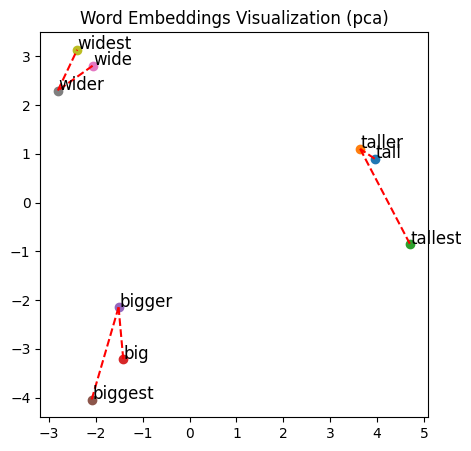

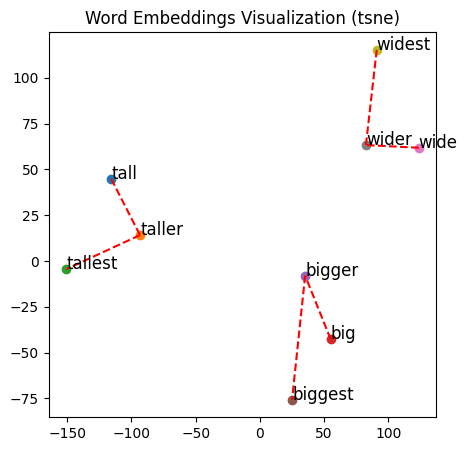

In [19]:
plot_embeddings_2d(model, words, method="PCA", line_plot = line_plot)
plot_embeddings_2d(model, words, method="tSNE", perplexity = 3, line_plot = line_plot)

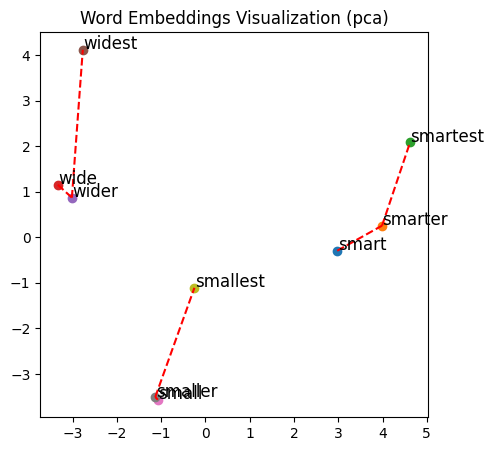

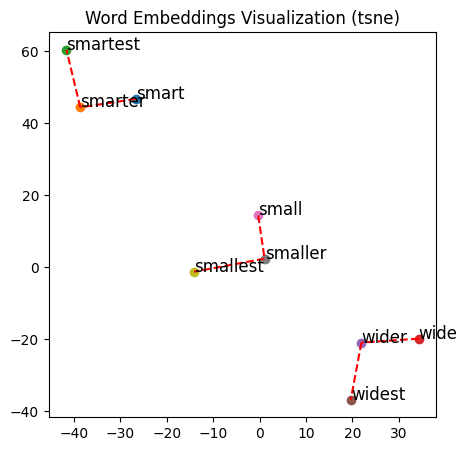

In [20]:
plot_embeddings_2d(model, words1, method="PCA", line_plot = line_plot1)
plot_embeddings_2d(model, words1, method="tSNE", perplexity = 3, line_plot = line_plot1)

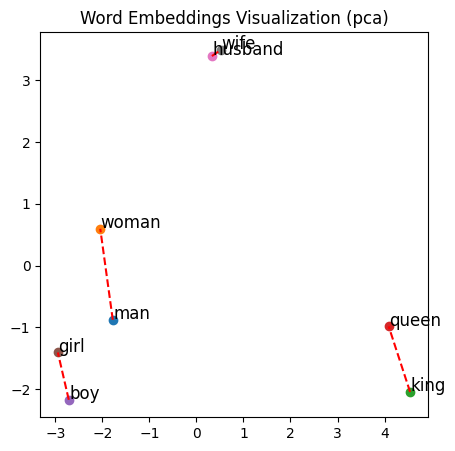

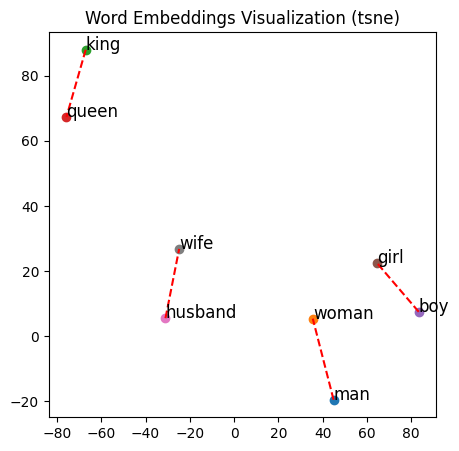

In [21]:
plot_embeddings_2d(model, words2, method="PCA", line_plot = line_plot2)
plot_embeddings_2d(model, words2, method="tSNE", perplexity = 3, line_plot = line_plot2)

## 2- Evaluation

### 2.1- Cosine similarity

To evaluate the quality of word vectors, we should look at the similarity of word vectors that are semantically similar, for example word *France* is similar to *Italy*, so their word vectors should be similar. One common metric to measure the distance between word vectors is the **cosine similarity**. The cosine similarity between two words $w_x$ and $w_y$ is defined as
$$
cos(w_x, w_y) = \frac{w_x^Tw_y}{||w_x|| ||w_y||}
$$
, where $||.||$ is the $l_2$ norm.

In [22]:
def cosine_similarity(u, v):
    numerator = sum(a * b for a, b in zip(u, v))
    denominator = (sum(a * a for a in u) ** 0.5) * (sum(b * b for b in v) ** 0.5)
    return numerator / denominator

def find_most_similar(word, model, top_n=5):
    target_vec = model.get_vector(word)
    word_similarities = []

    for other_word in model.index_to_key:
        if other_word == word:
            continue
        other_vec = model.get_vector(other_word)
        similarity = cosine_similarity(target_vec, other_vec)
        word_similarities.append((other_word, similarity))

    return sorted(word_similarities, key=lambda x: x[1], reverse=True)[:top_n]

similarity_france_tehran = cosine_similarity(model.get_vector("france"), model.get_vector("tehran"))
print(f"Cosine similarity between 'france' and 'tehran': {similarity_france_tehran}")

similarity_france_paris = cosine_similarity(model.get_vector("france"), model.get_vector("paris"))
print(f"Cosine similarity between 'france' and 'paris': {similarity_france_paris}")

top_5_similar_to_france = find_most_similar("france", model, top_n=5)
print(f"Top 5 words similar to 'france': {top_5_similar_to_france}")


Cosine similarity between 'france' and 'tehran': 0.24860086442580182
Cosine similarity between 'france' and 'paris': 0.6580672277272847
Top 5 words similar to 'france': [('french', 0.7344761017341762), ('paris', 0.6580672277272847), ('belgium', 0.6206723180229207), ('spain', 0.5735932363617855), ('italy', 0.5643459474349729)]


### 2.2- A little test set

One evaluation approach that was introduced in [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781) is to consider two pairs of words that have the same type of relationship, for example, *big - bigger* and *small - smaller*. Each two pairs can be viewed as a question: ”What is the word that is similar to small in the same sense as bigger is similar to big?”.

Interestingly, these questions can be answered by doing basic algebraic operations on the word vectors. First we compute $$x = w_{bigger}-w_{big}+w_{small}$$, and then search through all possible word vectors to find the closest one to $x$. In this notebook we use cosine similarity to measure closeness. So the problem can be written as $$ w^{*} = \arg\max_{w} cos(w, w_{bigger}-w_{big}+w_{small}) $$.

In [25]:
import numpy as np
import gensim.downloader as api

def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

test_set = [
    ["paris", "france", "toronto", "canada"],
    ["australia", "dollar", "japan", "yen"],
    ["chicago", "illinois", "stockton", "california"],
    ["brother", "sister", "father", "mother"],
    ["apparent", "apparently", "rapid", "rapidly"],
    ["possibly", "impossibly", "ethical", "ethically"],
    ["great", "greater", "tough", "tougher"],
    ["easy", "easiest", "lucky", "luckiest"],
    ["think", "thinking", "read", "reading"],
    ["switzerland", "swiss", "turkey", "turkish"],
    ["walking", "walked", "swimming", "swam"],
    ["mouse", "mice", "dollar", "dollars"],
    ["work", "works", "speak", "speaks"],
]

def analogy(model, words):
    word1, word2, word3, word4 = words
    vector1 = model.get_vector(word1)
    vector2 = model.get_vector(word2)
    vector3 = model.get_vector(word3)

    target = vector2 - vector1 + vector3

    best_match = None
    highest_score = -1

    for candidate in model.index_to_key:
        if candidate in (word1, word2, word3):
            continue
        current_score = cosine_similarity(target, model.get_vector(candidate))
        if current_score > highest_score:
            highest_score = current_score
            best_match = candidate

    return best_match, highest_score

def evaluate_analogy(model, test_set):
    correct_count = 0
    total = len(test_set)

    for test_words in test_set:
        prediction, _ = analogy(model, test_words)
        if prediction == test_words[3]:
            correct_count += 1

    return correct_count / total

accuracy = evaluate_analogy(model, test_set)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6923076923076923


## 3- Learn embeddings

This part goes through the process of cleaning a dataset, visualizing tokens, creating word embeddings using a co-occurrence matrix, and applying Singular Value Decomposition (SVD) to reduce dimensionality.

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np
import re
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

from gensim.models.phrases import Phrases, Phraser
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

### 3.1- Dataset Preprocessing

In this section, we will:

1. Load the Simpsons dataset.
2. Clean the text data by removing stop words, lemmatizing words, and filtering tokens.
3. Visualize the top tokens using a WordCloud.

In [3]:
root_path = '.' # Change this to the root path of your dataset
df = pd.read_csv(f'{root_path}/simpsons_dataset.csv')
print(f"Initial Dataset Shape: {df.shape}")
df

Initial Dataset Shape: (158314, 2)


,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
...,...,...
158309,Miss Hoover,I'm back.
158310,Miss Hoover,"You see, class, my Lyme disease turned out to ..."
158311,Miss Hoover,Psy-cho-so-ma-tic.
158312,Ralph Wiggum,Does that mean you were crazy?


In [4]:
df.isnull().sum()

,0
raw_character_text,17814
spoken_words,26459


In [6]:
df = df.dropna()
print(f"Dataset Shape after Dropping NaNs: {df.shape}")

Dataset Shape after Dropping NaNs: (131853, 2)


**Removing Stop Words in NLP Using NLTK:** Stop words are common words like "and," "the," or "is" that add little value to text analysis. In NLP, we use tools like NLTK to remove these words and focus on meaningful terms for better accuracy in tasks like sentiment analysis and classification.

For example consider this text:

*The quick brown fox jumps over the lazy dog.*

After removing stop words `["the", "over"]`, we get:

*quick brown fox jumps lazy dog.*

By eliminating stop words, the processed text becomes more concise and meaningful for analysis.

In the cell below, download the NLTK stopwords and WordNet modules. You can also add custom stopwords.

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [8]:
stop_words = set(stopwords.words('english'))

# Add custom stop words
stop_words.update([
    "i'm", "i'll", "this'll", "what'l", "that's", "he", "he'd", "she", "she'd",
    "it", "they", "him", "her", "his", "their", "but", "for", "nor", "so",
    "with", "by", "be", "have", "do", "can", "will", "may", "very", "really",
    "just", "then", "now", "there", "where", "how", "like", "uh", "um",
    "you know", "oh", "well",
    "that", "these", "those", "each", "every", "some", "any", "all",
    "one", "two", "three", "four", "five", "six", "seven", "eight",
    "nine", "ten", "much", "many", "more", "most", "less", "least",
    "same", "other", "another", "which", "whoever", "whomever",
    "whichever", "whatsoever", "could", "would", "should", "might",
    "must", "shall", "can", "may", "if", "as", "than", "while",
    "because", "although", "since", "unless", "whereas", "before",
    "after", "during", "while", "about", "along", "among", "but",
    "yet", "for", "nor", "so", "either", "neither", "whether",
    "instead", "regarding", "despite", "although", "not", "never",
    "ever", "just", "really", "very", "quite", "too", "still",
    "yet", "also", "especially", "particularly", "simply",
    "actually", "literally", "essentially", "virtually", "truly",
    "specially", "in fact", "on the other hand", "in addition",
    "meanwhile", "however", "therefore", "furthermore", "likewise",
    "consequently", "subsequently", "additionally", "moreover",
    "notably", "here", "there", "when", "where", "what", "why","aw","oooh",
    "who", "whom", "whose", "which", "how", "a", "an", "the","who's",
])

print(stop_words)

{'truly', "you're", "won't", 'five', 'might', 'with', 'up', 'yet', 'likewise', 'she', 'at', 'hasn', 'haven', 'on', 'ten', 'her', 'few', "mustn't", 'below', 'an', 'further', 'whose', 'wasn', 'he', 'until', 'while', "this'll", 'm', 'moreover', "couldn't", 'on the other hand', 'really', 'ever', 'before', 'have', 'which', 'four', 'himself', 'another', 'by', 'whatsoever', 'shan', 'would', "should've", 'weren', 'our', 'about', 'me', 'then', 'for', 'any', 'too', 'may', 'same', "shouldn't", 'three', 'meanwhile', 'when', 'above', 'been', 'll', "i'll", 'also', 'yourselves', 'ma', 'neither', 'aren', 'in addition', 'did', 'between', "hadn't", 'his', 'in', 'their', "he'd", 'one', 'quite', 'specially', 'under', 'furthermore', 'still', 'hadn', 'won', 'only', "you've", "she's", "mightn't", 'unless', "doesn't", "hasn't", 'whichever', 'notably', 's', 'whereas', 'am', 'so', 'themselves', 'was', 'can', 'we', 'him', 'other', 'out', 'you know', 'every', 'each', 'aw', 'is', 'shouldn', 'that', 'nine', 'whom',

The `WordNetLemmatizer` is a tool provided by NLTK that reduces words to their base or root form, known as the **lemma**, while ensuring the word remains meaningful in context. **Lemmatization** uses linguistic rules and a vocabulary (WordNet) to produce valid dictionary words.
For example:
- `"running"` becomes `"run"`  
- `"better"` becomes `"good"`  

The `clean_text` function preprocesses input text to prepare it for NLP tasks by performing the following steps:

1. **Remove Non-Alphabetic Characters**:  
   Removes characters that aren't letters to clean the text like punctuation and numbers.

2. **Lowercase Conversion**:
   Converts all letters to lowercase for uniformity.

3. **Tokenization and Stop Word Removal**:  
   Breaks the text into individual words (in this case **tokens**) and removes common stop words to focus on meaningful terms.  

4. **Lemmatization**:  
   Converts each word to its root form using the `WordNetLemmatizer` for better consistency in analysis.  

After this preprocesses we have:

- Input: `"The running dogs quickly jumped over fences!"`  
- Output: `"run dog quick jump fence"`  

The function ensures the text is simplified and meaningful, helping improve the performance of NLP tasks such as text classification or sentiment analysis. If the cleaned text has fewer than three words, it skips the text.

In [9]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Cleans input text by removing non-alphabetic characters,
     lowercasing, removing stopwords, and lemmatizing."""

    # Remove special characters and convert to lowercase
    cleaned = ''.join(char for char in text if char.isalpha() or char.isspace()).lower()

    # Split into words and process each word
    words = cleaned.split()
    processed_words = []

    # Process each word - remove stopwords and lemmatize
    for word in words:
        if word not in stop_words:
            lemmatized = lemmatizer.lemmatize(word)
            processed_words.append(lemmatized)

    # Return result if we have enough words
    if len(processed_words) > 2:
        return ' '.join(processed_words)
    return None

In [11]:
df['spoken_words_clean'] = df['spoken_words'].apply(clean_text)

df.head()

,raw_character_text,spoken_words,spoken_words_clean
0,Miss Hoover,"No, actually, it was a little of both. Sometim...",little sometimes disease magazine news show na...
1,Lisa Simpson,Where's Mr. Bergstrom?,wheres mr bergstrom
2,Miss Hoover,I don't know. Although I'd sure like to talk t...,dont know id sure talk didnt touch lesson plan...
3,Lisa Simpson,That life is worth living.,life worth living
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...,poll open end recess case decided put thought ...


After cleaning some values might become NaN, remove them. Then Display cleaned dataframe.

In [12]:
# Clean DataFrame by processing in steps
df_clean = (df
    .dropna(subset=['spoken_words_clean'])  # Remove rows with NaN values
    .drop_duplicates(subset=['spoken_words_clean'])  # Remove duplicate rows
    .assign(clean=lambda x: x['spoken_words_clean'])  # Create new column
    .drop('spoken_words_clean', axis=1)  # Drop old column
)

# Show the results
print(f"Cleaned Dataset Shape: {df_clean.shape}")
df_clean

Cleaned Dataset Shape: (92699, 3)


,raw_character_text,spoken_words,clean
0,Miss Hoover,"No, actually, it was a little of both. Sometim...",little sometimes disease magazine news show na...
1,Lisa Simpson,Where's Mr. Bergstrom?,wheres mr bergstrom
2,Miss Hoover,I don't know. Although I'd sure like to talk t...,dont know id sure talk didnt touch lesson plan...
3,Lisa Simpson,That life is worth living.,life worth living
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...,poll open end recess case decided put thought ...
...,...,...,...
158289,Lisa Simpson,"Oh, Mom, that's wonderful. Can I find out his ...",mom thats wonderful find favorite dish help make
158293,Lisa Simpson,Can I get my ears pierced?,get ear pierced
158295,Lisa Simpson,Can I dye my shoes pink?,dye shoe pink
158307,Lisa Simpson,"Mr. Bergstrom, we request the pleasure of your...",mr bergstrom request pleasure company mr bergs...


In [13]:
sample_examples = df_clean.sample(5, random_state=8)

print("=== Sample Cleaning Examples ===\n")

for index, row in sample_examples.iterrows():
    print(f"Example {index + 1}:")
    print(f"------------------")
    print(f"Original: {row['spoken_words']}")
    print(f"Cleaned:  {row['clean']}")
    print(f"------------------\n")

print("===============================")

=== Sample Cleaning Examples ===

Example 126562:
------------------
Original: Now you can see why I can't stay in one place. Not here, not anywhere.
Cleaned:  see cant stay place anywhere
------------------

Example 86745:
------------------
Original: I can still hear her. I'd better do something.
Cleaned:  hear id better something
------------------

Example 146120:
------------------
Original: Don't be alarmed. I am a trained humanologist. Let me just check your heart.
Cleaned:  dont alarmed trained humanologist let check heart
------------------

Example 62125:
------------------
Original: Book writing, what a scam, huh! It's only twenty pages long, and this guy wrote it for me!
Cleaned:  book writing scam huh twenty page long guy wrote
------------------

Example 134356:
------------------
Original: Oh, I just came here to pick up my daughter. But now I'm gonna kill you all!
Cleaned:  came pick daughter im gonna kill
------------------



To continue, let's only keep the preprocessed texts.

In [14]:
df_clean = df_clean.drop(columns=['spoken_words'])
df_clean

,raw_character_text,clean
0,Miss Hoover,little sometimes disease magazine news show na...
1,Lisa Simpson,wheres mr bergstrom
2,Miss Hoover,dont know id sure talk didnt touch lesson plan...
3,Lisa Simpson,life worth living
4,Edna Krabappel-Flanders,poll open end recess case decided put thought ...
...,...,...
158289,Lisa Simpson,mom thats wonderful find favorite dish help make
158293,Lisa Simpson,get ear pierced
158295,Lisa Simpson,dye shoe pink
158307,Lisa Simpson,mr bergstrom request pleasure company mr bergs...


The **`WordCloud`** library in Python is used to create visual representations of text data, where word size reflects its frequency or importance. It offers customizable options like background color, dimensions, and stop word filtering, making it a powerful tool for quickly analyzing text patterns.

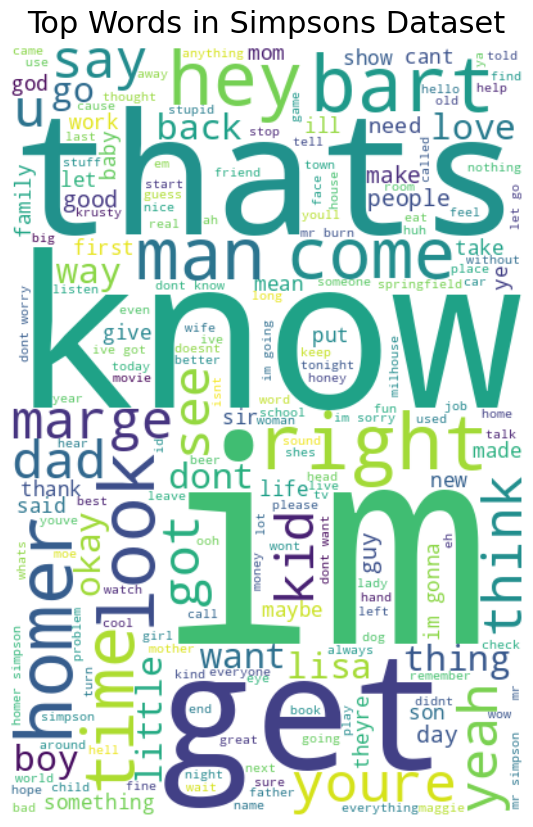

In [15]:
text = ' '.join(df_clean['clean'].dropna())

wc = WordCloud(
    background_color='white',
    stopwords=stop_words,
    max_words=200,
    height=600,
    width=400,
).generate(text)

plt.figure(figsize=(18, 10))
plt.title('Top Words in Simpsons Dataset', fontdict={'size': 22, 'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3.2- Tokenization and Phrase Detection

In this section, we will tokenize cleaned sentences and use the Gensim Phrases and Phraser tools to detect common bigrams in the text.

Tokenization is the process of splitting text into individual words or tokens. In this case, we will split each sentence in `df_clean['clean']` into a list of words, preparing the text for further analysis, such as phrase detection.

**Original Sentence:**  
```python
The quick brown fox jumps over the lazy dog.
```

**Tokenized Output:**  
```python
['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
```

This step transforms the text into a format that is easier to work with in subsequent analyses.

In [16]:
sentences = list(map(str.split, df_clean['clean'].dropna()))

sentences[:2]

[['little',
  'sometimes',
  'disease',
  'magazine',
  'news',
  'show',
  'natural',
  'think'],
 ['wheres', 'mr', 'bergstrom']]

In this part, we perform two key tasks: detecting common **bigrams** (pairs of words) in the text and calculating the **frequency** of each word, including bigrams, in the dataset.

The `Phrases` tool from Gensim is used to detect common bigrams in the tokenized sentences. The `min_count ` argument ensures that only bigrams appearing at least five times are considered, and `threshold ` filters out less significant bigrams. The `Phraser` tool speeds up the transformation by creating a more efficient bigram model.

The model is applied to the tokenized sentences, enriching the text with detected bigrams.

If the input text contains the sentences:  
- "The quick brown fox"
- "The quick fox jumps"

After bigram detection, common bigrams like `("quick", "fox")` might be added.

In [18]:
bigram_model = Phrases(sentences, threshold=10, min_count=5, delimiter=' ')  # Detect common bigrams
bigram_phraser = Phraser(bigram_model)  # Create a more efficient bigram model
sentences_with_bigrams = list(bigram_phraser[sent] for sent in sentences)  # Transform sentences

# Display the first two sentences with detected bigrams
sentences_with_bigrams[:2]

[['little',
  'sometimes',
  'disease',
  'magazine',
  'news',
  'show',
  'natural',
  'think'],
 ['wheres', 'mr bergstrom']]

Use `defaultdict` to count how often each word (including bigrams) appears across all sentences. then print total number of unique words.

In [19]:
from collections import defaultdict

word_freq = defaultdict(int)
for sentence in sentences_with_bigrams:
    for word in sentence:
        word_freq[word] += 1

print(f"Total unique words: {len(word_freq)}")

Total unique words: 39462


### 3.3- Co-occurrence Matrix

In this section, we will build a co-occurrence matrix to analyze how often two words appear together within a specific context window.

The **context window** defines how many words before and after a given word will be considered as its context. For example, a context window size of 2 means each word is compared with the two words before and after it.

A threshold for word frequency (`min_freq = 10`) ensures that only words appearing at least 10 times in the text are included in the vocabulary. This reduces noise from infrequent words.

The **co-occurrence matrix** is a square matrix where both rows and columns represent the words in the filtered vocabulary. If the vocabulary size is $N$, which is the number of unique words, the matrix will have a shape of $(N \times N)$. Each entry $[i, j]$ in the matrix shows the count of how often word $i$ appears with word $j$ within the context window.

For each sentence, we iterate through its words. For each word, its context (words within the context window) is identified, and the corresponding matrix entries are incremented. A larger context window increases the number of words included as context for each word, leading to more entries being updated in the matrix. Conversely, a smaller window focuses on closer relationships, resulting in sparser updates.

Let's see an example. Consider the following sentence with context window of $2$
```python
"The quick brown fox jumps."
```

For the word `"quick"`, its context words are `"the"`, `"brown"`, and `"fox"`. The co-occurrence matrix will be updated at positions corresponding to these pairs:  
```python
('quick', 'the'), ('quick', 'brown'), ('quick', 'fox')
```

This is repeated for each word in the sentence.

In [50]:
CONTEXT_WINDOW = 2
min_freq = 10

filtered_vocab = {word: idx for idx, (word, freq) in enumerate(word_freq.items()) if freq >= min_freq}
vocab_size = len(filtered_vocab)

# Reinitialize the co-occurrence matrix to match the filtered vocabulary size
co_occurrence_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

# Update the co-occurrence matrix
for sentence in sentences_with_bigrams:
    for i, word in enumerate(sentence):
        if word not in filtered_vocab:
            continue
        word_idx = filtered_vocab[word]
        start = max(0, i - CONTEXT_WINDOW)
        end = min(len(sentence), i + CONTEXT_WINDOW + 1)
        for j in range(start, end):
            if i != j:
                context_word = sentence[j]
                if context_word in filtered_vocab:
                    context_word_idx = filtered_vocab[context_word]
                    # Ensure indices are within bounds
                    if word_idx < vocab_size and context_word_idx < vocab_size:
                        co_occurrence_matrix[word_idx, context_word_idx] += 1

print(f"Co-occurrence Matrix Shape: {co_occurrence_matrix.shape}")


Co-occurrence Matrix Shape: (6492, 6492)


### 3.4- SVD

In this section, students will apply Singular Value Decomposition (SVD) to reduce the dimensionality of the co-occurrence matrix and visualize word embeddings in a 2D and 3D space.

After performing SVD on the co-occurrence matrix, it is factorized into three matrices:
- $U$: Represents the left singular vectors, capturing word relationships.
- $\Sigma$: A diagonal matrix of singular values, representing the importance of each dimension.
- $V^T$: Represents the right singular vectors, capturing document or context relationships.

We use the $U$ matrix as the **new word embeddings** because it captures word-to-word relationships in a reduced-dimensional space. By truncating $U$ to the top $k$ dimensions (corresponding to the largest singular values in $\Sigma$), we retain the most important features while discarding noise and less informative components.

In [51]:
from scipy.sparse.linalg import svds
import numpy as np

n_components = 64

# Convert matrix to float32
co_occurrence_matrix = np.float32(co_occurrence_matrix)

u, s, vt = svds(A=co_occurrence_matrix, k=n_components, which='LM')

# Use left singular vectors as embeddings
reduced_embeddings = u

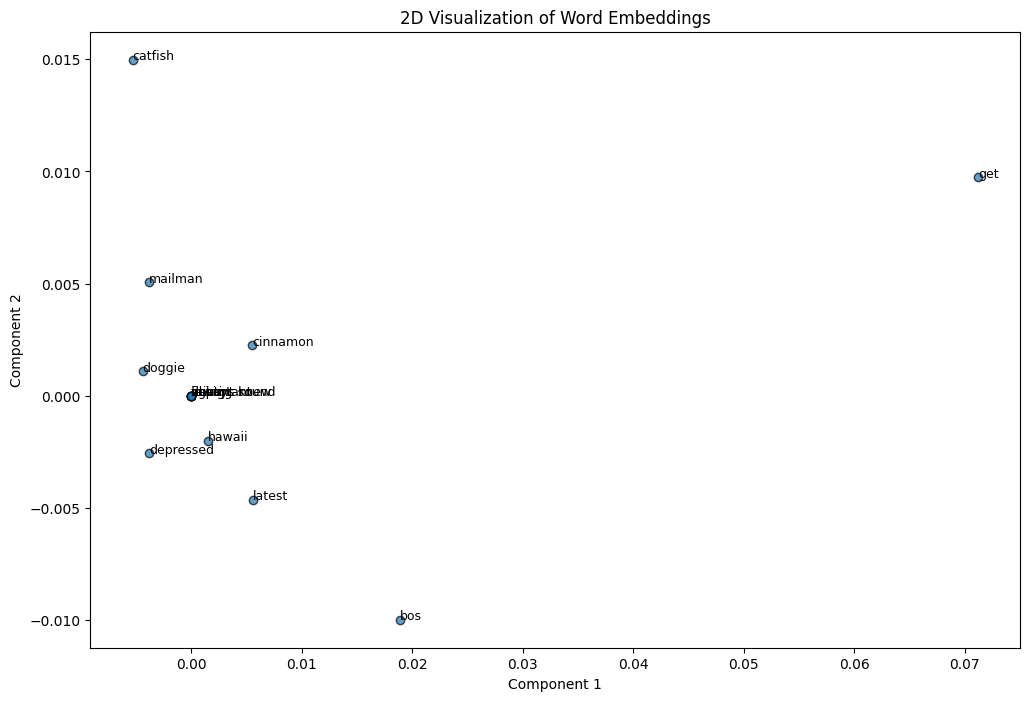

In [52]:
def visualize_embeddings(embeddings, vocab, dim=2, num_words=100):
    if dim not in (2, 3):
        raise ValueError("Visualization dimension must be 2 or 3.")

    # TODO: Select random subset of words and embeddings
    sample_size = min(num_words, len(vocab))
    indices = np.random.permutation(len(vocab))[:sample_size]
    words = [vocab[i] for i in indices]
    vectors = embeddings[indices, :dim]

    if dim == 2:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(*vectors.T, alpha=0.7, edgecolor='k')
        for word, (x, y) in zip(words, vectors):
            ax.annotate(word, (x, y), fontsize=9)
        ax.set_title('2D Visualization of Word Embeddings')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')

    else:  # dim == 3
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(*vectors.T, alpha=0.7, edgecolor='k')
        for word, (x, y, z) in zip(words, vectors):
            ax.text(x, y, z, word, fontsize=9)
        ax.set_title('3D Visualization of Word Embeddings')
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')

    plt.show()

# Map indices to words and visualize
vocab = [word for word, _ in sorted(filtered_vocab.items(), key=lambda x: x[1])]
visualize_embeddings(reduced_embeddings, vocab, dim=2, num_words=15)

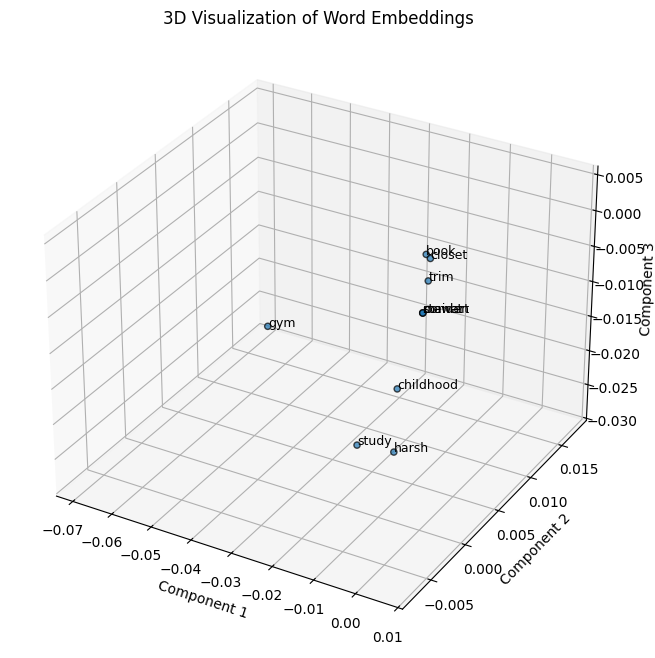

In [53]:
visualize_embeddings(reduced_embeddings, vocab, dim=3, num_words=10)

### 3.5- Similarity

In this part, we will compute cosine similarity between word embeddings to find words that are semantically similar or dissimilar. Cosine similarity is a measure of similarity between two vectors, calculated by measuring the cosine of the angle between them. A cosine similarity close to 1 indicates high similarity, while a value close to -1 indicates dissimilarity.

1. **get_similar_words**:  
   This function computes the similarity between a given word and all other words in the vocabulary. It returns the top N words most similar to the given word, based on cosine similarity.

2. **get_dissimilar_words**:  
   This function works similarly to `get_similar_words` but returns words that are the most dissimilar to the input word. It finds the top N words that have the lowest cosine similarity to the input word.

3. **get_closest_words_to_vector**:  
   This function finds the closest words to a random vector in the embedding space. It calculates the cosine similarity between the random vector and all word embeddings and returns the top N closest words.

4. **find_analogy**:  
   This function solves word analogies like "king - man + woman = ?" by subtracting the vector of word B from word A and adding the vector of word C. The resulting vector represents the analogy, and the function returns the words closest to this analogy vector.

5. **get_neighbors_of_group**:  
   This function calculates the collective nearest neighbors for a group of words. It averages the word vectors of the given group of words and finds the most similar words to this average vector.

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_similar_words(word, top_n=5, embedding_dim=10):
    filtered_vocab = {word: idx for idx, (word, freq) in enumerate(word_freq.items()) if freq >= min_freq}
    """
    Finds similar words based on cosine similarity.

    Args:
    - word: The word to find similarities for.
    - top_n: Number of similar words to return.
    - embedding_dim: Dimensionality of embeddings to use.

    Returns:
    - List of tuples with similar words and their similarity scores.
    """
    if word not in filtered_vocab:
        raise ValueError(f"'{word}' not found in the vocabulary.")

    # TODO: Use the selected dimensions for similarity calculation
    word_idx = filtered_vocab[word]
    target_vector = reduced_embeddings[word_idx, :embedding_dim].reshape(1, -1)
    all_vectors = reduced_embeddings[:, :embedding_dim]

    # Calculate similarities for all words at once
    similarities = cosine_similarity(target_vector, all_vectors)[0]

    # Create (word, similarity) pairs and remove the target word
    word_sims = [(w, similarities[filtered_vocab[w]])
                 for w in filtered_vocab if w != word]

    return sorted(word_sims, key=lambda x: x[1], reverse=True)[:top_n]

In [59]:
# Display some similar words to main characters of simpsons (homer , lisa , bart , ...)
# For example we know homer is lazy and hopeless can embeddings caputure this ?
# Adjust your embedding_dim
word = 'homer'

In [26]:
# Checkout lisa
word = 'lisa'

In [27]:
# What about bart
word = 'simp'

In [61]:
def get_dissimilar_words(word, top_n=5, embedding_dim=10):
    filtered_vocab ={word: idx for idx, (word, freq) in enumerate(word_freq.items()) if freq >= min_freq}
    """
    Finds dissimilar words based on cosine similarity.

    Args:
    - word: The word to find dissimilarities for.
    - top_n: Number of dissimilar words to return.
    - embedding_dim: Dimensionality of embeddings to use.

    Returns:
    - List of tuples with dissimilar words and their similarity scores.
    """
    if word not in filtered_vocab:
        raise ValueError(f"'{word}' not found in the vocabulary.")

    # Get the index and embedding of the target word
    word_idx = filtered_vocab[word]
    word_vector = reduced_embeddings[word_idx, :embedding_dim]

    # Initialize a list to store word-similarity pairs
    similarities = []

    # Iterate through the vocabulary to calculate similarity
    for other_word, other_idx in filtered_vocab.items():
        if other_idx >= reduced_embeddings.shape[0]:  # Ensure index is within bounds
            continue
        if other_word != word:  # Skip the word itself
            other_vector = reduced_embeddings[other_idx, :embedding_dim]
            similarity = cosine_similarity([word_vector], [other_vector])[0][0]
            similarities.append((other_word, similarity))

    # Sort by similarity in ascending order and return the top N
    similarities.sort(key=lambda x: x[1])  # Ascending order
    return similarities[:top_n]

dissimilar_words_homer = get_dissimilar_words('lisa', top_n=5, embedding_dim=10)
print("Dissimilar Words to 'homer':", dissimilar_words_homer)

Dissimilar Words to 'homer': [('exist', -0.90883845), ('interrupt', -0.8374724), ('share', -0.8349542), ('serve', -0.82331246), ('bart', -0.8013543)]


In [62]:
def get_closest_words_to_vector(vector, top_n=5, embedding_dim=10):
    """
    Finds words closest to a given vector in embedding space.

    Args:
    - vector: A vector (numpy array) to compare against embeddings.
    - top_n: Number of closest words to return.
    - embedding_dim: Dimensionality of embeddings to use.

    Returns:
    - List of tuples with closest words and their similarity scores.
    """
    # Normalize the input vector for consistent cosine similarity
    vector = vector[:embedding_dim]
    vector_norm = vector / np.linalg.norm(vector)

    # Calculate cosine similarity with all embeddings
    similarities = []
    for word, idx in filtered_vocab.items():
        if idx >= reduced_embeddings.shape[0]:
            continue
        embedding = reduced_embeddings[idx, :embedding_dim]
        embedding_norm = embedding / np.linalg.norm(embedding)
        similarity = np.dot(vector_norm, embedding_norm)
        similarities.append((word, similarity))

    # Sort by similarity in descending order and return the top N
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# TODO: Find closest words to a random vector (≈3 lines)
random_vector = np.random.rand(reduced_embeddings.shape[1])  # Generate a random vector
closest_words = get_closest_words_to_vector(random_vector, top_n=5, embedding_dim=10)
print("Closest Words to Random Vector:", closest_words)


Closest Words to Random Vector: [('screen', 0.89566790639182), ('whats', 0.8103762452750884), ('hitler', 0.8091294466236548), ('butt', 0.8042141900493708), ('fan', 0.800404243553612)]


In [64]:
def find_analogy(word_a, word_b, word_c, top_n=1, embedding_dim=10):
    """
    Word analogy solver using embeddings
    """
    valid_words = all(word in filtered_vocab for word in (word_a, word_b, word_c))
    if not valid_words:
        invalid = next(word for word in (word_a, word_b, word_c) if word not in filtered_vocab)
        raise ValueError(f"Error: {invalid} missing from vocab")

    dim_range = slice(None, embedding_dim)
    vecs = {
        'a': reduced_embeddings[filtered_vocab[word_a], dim_range],
        'b': reduced_embeddings[filtered_vocab[word_b], dim_range],
        'c': reduced_embeddings[filtered_vocab[word_c], dim_range]
    }

    target = vecs['a'] - vecs['b'] + vecs['c']
    target /= np.linalg.norm(target)

    results = []
    vocab_items = filtered_vocab.items()

    for word, index in vocab_items:
        if index < reduced_embeddings.shape[0]:
            curr_vec = reduced_embeddings[index, dim_range]
            norm_curr = curr_vec / np.linalg.norm(curr_vec)
            sim_score = float(target @ norm_curr)
            results.append((word, sim_score))

    results.sort(key=lambda x: -x[1])
    return results[:top_n]

# Testing analogy solver
analogy_result = find_analogy('bart', 'man', 'woman', top_n=6, embedding_dim=10)
print("Result of analogy 'bart - man + woman':", analogy_result)

Result of analogy 'bart - man + woman': [('fresh', 0.8352333307266235), ('delicious', 0.8216008543968201), ('love', 0.7956668138504028), ('suppose', 0.7906617522239685), ('greet', 0.7890486121177673), ('halloween', 0.7861711978912354)]


In [65]:
def get_neighbors_of_group(words, top_n=5, embedding_dim=10):
    """
    Group-based neighbor finder
    """
    if any(w not in filtered_vocab for w in words):
        bad_word = next(w for w in words if w not in filtered_vocab)
        raise ValueError(f"Vocab missing: {bad_word}")

    vectors = []
    for term in words:
        vec = reduced_embeddings[filtered_vocab[term]][:embedding_dim]
        vectors.append(vec)

    center = np.mean(vectors, axis=0)
    center_norm = center / np.linalg.norm(center)

    output = []
    for term, idx in filtered_vocab.items():
        if idx >= reduced_embeddings.shape[0]:
            continue

        curr = reduced_embeddings[idx][:embedding_dim]
        curr_norm = curr / np.linalg.norm(curr)
        dist = float(center_norm @ curr_norm)

        if term not in words:
            output.append((term, dist))

    output.sort(key=lambda pair: -pair[1])
    return output[:top_n]

# Finding closest words
result = get_neighbors_of_group(['homer', 'bart'], top_n=5, embedding_dim=10)
print(f"Most similar to homer & bart: {result}")

Most similar to homer & bart: [('acid', 0.9372722506523132), ('wash', 0.854786217212677), ('bait', 0.8473372459411621), ('fame', 0.8470182418823242), ('xray', 0.8311321139335632)]


## 4- Sentiment Analysis of MDB Movie Reviews

In this section, we want to assign a positive/negative lable to a user review for a movie. We will use LSTM, a version of RNN, to process the embeddings. We use the previous embeddings for this section. Let's dive in!

In [66]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import re
from tqdm import tqdm

### 4.1- Dataset

Here we load the dataset. the dataset consists of $5000$ reviews (the original dataset has $50000$ rows, for time constraints, we just use the first $5000$ rows of reviews) with their sentiment ,positive or negative.

In [67]:
df = pd.read_csv('IMDB Dataset_small.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
4995,An interesting slasher film with multiple susp...,negative
4996,i watched this series when it first came out i...,positive
4997,Once again Jet Li brings his charismatic prese...,positive
4998,"I rented this movie, after hearing Chris Gore ...",negative


First, let's remove unnecessary words from each review. And also map the sentiment to numerical binary values.

In [68]:
def preprocess_string(s):
   # Clean special chars
   text = re.sub(r'[^\w\s]', '', s)

   # Fix spaces
   text = re.sub(r'\s+', ' ', text)

   # Remove numbers
   text = re.sub(r'\d+', '', text)

   return text.strip()

# Process reviews
df['review'] = df['review'].apply(preprocess_string)

# Convert sentiment
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production br br The filmin...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1
...,...,...
4995,An interesting slasher film with multiple susp...,0
4996,i watched this series when it first came out i...,1
4997,Once again Jet Li brings his charismatic prese...,1
4998,I rented this movie after hearing Chris Gore s...,0


Plot the histogram of reviews lengths.

Text(0.5, 1.0, 'Distribution of Review Lengths (Word Count)')

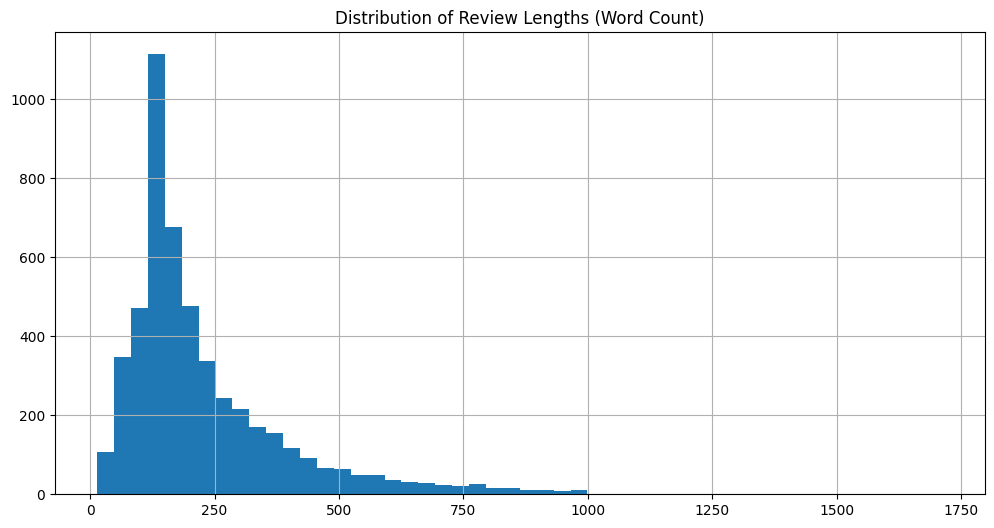

In [69]:
df['review'].str.split().str.len().hist(bins=50, figsize=(12, 6))
plt.title('Distribution of Review Lengths (Word Count)')


Write the tokenize function to tokenize each word. You can use your previous vocabulary. This cell will take about $2$ minutes.

In [71]:
def _tokenize(s):
   return [filtered_vocab[word] for word in s.split() if word in filtered_vocab]

# Tokenize text
X = df['review'].apply(_tokenize).tolist()

# Show first 5
X[:5]

[[9468,
  1178,
  8550,
  229,
  4560,
  73,
  3304,
  571,
  163,
  259,
  372,
  6432,
  6317,
  795,
  73,
  778,
  5,
  5,
  3466,
  6317,
  2787,
  723,
  195,
  3304,
  13757,
  4226,
  2300,
  6486,
  423,
  369,
  6972,
  925,
  17764,
  290,
  1426,
  4980,
  1337,
  37,
  8239,
  3603,
  5,
  10471,
  4131,
  512,
  513,
  721,
  5333,
  436,
  11513,
  436,
  1195,
  2400,
  617,
  259,
  8550,
  115,
  6432,
  3304,
  1749,
  494,
  37,
  1555,
  3304,
  5242,
  6408,
  517,
  72,
  925,
  6317,
  6317,
  8020,
  11114,
  1032,
  4463,
  11114,
  1912,
  1858,
  161,
  613,
  129,
  130,
  941,
  6486,
  10471,
  1400,
  3458,
  6486,
  3269,
  4661,
  2651,
  12203,
  10608,
  161,
  16,
  402],
 [397,
  0,
  1818,
  10650,
  1,
  330,
  2727,
  1085,
  1448,
  10477,
  72,
  49,
  9808,
  10608,
  368,
  12481,
  21,
  1178,
  1602,
  3981,
  1085,
  1818,
  394,
  799,
  3543,
  20,
  290,
  0,
  11309,
  10241,
  6170,
  723,
  54,
  1267,
  10089,
  5861,
  3525,
  265

Pad the sentences to a fixed size $512$. If they are longer, truncate them.

In [73]:
def padding_(sentences, seq_len):
   result = np.zeros((len(sentences), seq_len), dtype=int)

   for idx, sent in enumerate(sentences):
       length = min(len(sent), seq_len)
       result[idx, :length] = sent[:length]

   return result

# Pad sequences
X = padding_(X, 512)

print(f"Shape after padding: {X.shape}")
print("First 2 sequences:")
print(X[:2])

Shape after padding: (5000, 512)
First 2 sequences:
[[9468 1178 8550 ...    0    0    0]
 [ 397    0 1818 ...    0    0    0]]


In [74]:
y = df['sentiment'].values
assert X.shape == (5000, 512) and y.shape == (5000,)

Use `reduced_embeddings` from the previous section to make the input in shape $N \times L \times D$, where $N=5000$ is the number of the rows, $L=512$ is the sequence length for each review, and $D=64$ is the dimension of embeddings after SVD.

In [76]:
embedding_dim = reduced_embeddings.shape[1]
X = np.array([
   [reduced_embeddings[tok] if tok < reduced_embeddings.shape[0] else np.zeros(embedding_dim)
    for tok in seq] for seq in X
])

print(f'Embedding matrix shape: {X.shape}')

Embedding matrix shape: (5000, 512, 64)


In this part split the dataset into train and validation sets. Use [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) to create batches of the input data.

In [77]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)} | Validation size: {len(X_val)}")

Train size: 4000 | Validation size: 1000


In [78]:
# Convert to tensors
train_ds = TensorDataset(
   torch.tensor(X_train, dtype=torch.float32),
   torch.tensor(y_train, dtype=torch.float32)
)

val_ds = TensorDataset(
   torch.tensor(X_val, dtype=torch.float32),
   torch.tensor(y_val, dtype=torch.float32)
)

batch_size = 50

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 80
Val batches: 20


The bellow cell is to get familiar with dataloaders.

In [79]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input x shape:', sample_x.shape)
print('Sample input y shape:', sample_y.shape)

Sample input x shape: torch.Size([50, 512, 64])
Sample input y shape: torch.Size([50])


You may need GPU for faster training.

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 4.2- Model

In this part, you are supposed to implement key components of a recurrent neural network (RNN) for sentiment analysis using **PyTorch**. Initialize the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) using `nn` in torch, and a fully connected layer.

You just need to implement the forward pass of the model. PyTorch will calculate the gradients automatically (we will see how) and do backpropagation for us, which makes dealing with complex models super easier.

LSTM has two hiddens, for simplicity initialize them to zero vectors.

In [82]:
class SentimentRNN(nn.Module):
    def __init__(self, n_layers, hidden_dim, embedding_dim):
        super(SentimentRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        lstm_out, hidden = self.lstm(x, hidden)

        lstm_out = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_dim)

        fc_out = self.fc(lstm_out)
        sig_out = self.sigmoid(fc_out)

        return sig_out, hidden

    def init_hidden(self, batch_size, device):
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)

        hidden = (h0, c0)
        return hidden


In [83]:
n_layers = 3
embedding_dim = 64
hidden_dim = 128

model = SentimentRNN(n_layers, hidden_dim, embedding_dim)
model.to(device)

SentimentRNN(
  (lstm): LSTM(64, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [84]:
example_input = torch.randn(50, 512, 64, device=device)
hidden = model.init_hidden(50, device)
output, hidden = model(example_input, hidden)
print(f"Output shape: {output.shape}")

Output shape: torch.Size([50, 1])


### 4.3- Train

Use [BCE](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) for loss function. [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) is another optimizer that similar to Gradient Descent, its main idea is taking step on the opposite side of the gradients. We will need `acc` function to evaluate our model on unseen data.

In [85]:
lr = 0.0003
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def acc(pred: torch.Tensor, label: torch.Tensor) -> int:
   """
   Calculate prediction accuracy
   """
   predictions = torch.round(pred)
   correct = (predictions == label).sum().item()
   return (correct / len(label)) * 100

This [blog](https://pytorch.org/blog/overview-of-pytorch-autograd-engine/) explains how PyTorch computes gradients. Basically, the main core of it is using chain rule. It stores all the basic derivatives in [derivatives](https://github.com/pytorch/pytorch/blob/a0a7a2d648f05b0192e6943c9684406cdf404fbf/tools/autograd/derivatives.yaml#L635-L636), then for every possible function, PyTorch breaks them down to basic functions which the derivatives are known.

We now train our model using this powerful library. See [this](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) if you need more information about how optimization works in PyTorch. We use gradient clipping, whihc might be helpful for RNNs.

In [87]:
clip = 5
epochs = 10
best_val_loss = np.Inf
prev_loss = np.Inf

tr_losses, val_losses = [], []
tr_accs, val_accs = [], []

for epoch in range(epochs):
   model.train()
   batch_losses = []
   batch_acc = 0
   h = model.init_hidden(batch_size, device)

   for inputs, labels in tqdm(train_loader, total=len(train_loader)):
       inputs = inputs.to(device)
       labels = labels.to(device)
       h = tuple([x.data for x in h])

       optimizer.zero_grad()
       output, h = model(inputs, h)
       loss = criterion(output.squeeze(), labels)
       loss.backward()

       batch_losses.append(loss.item())
       batch_acc += acc(output.squeeze(), labels)

       nn.utils.clip_grad_norm_(model.parameters(), clip)
       optimizer.step()

   model.eval()
   val_losses_batch = []
   val_acc = 0
   val_h = model.init_hidden(batch_size, device)

   with torch.no_grad():
       for inputs, labels in valid_loader:
           inputs = inputs.to(device)
           labels = labels.to(device)

           out, val_h = model(inputs, val_h)
           val_loss = criterion(out.squeeze(), labels)
           val_losses_batch.append(val_loss.item())
           val_acc += acc(out.squeeze(), labels)

   train_loss = np.mean(batch_losses)
   valid_loss = np.mean(val_losses_batch)
   train_acc = batch_acc / len(train_loader.dataset)
   valid_acc = val_acc / len(valid_loader.dataset)

   tr_losses.append(train_loss)
   val_losses.append(valid_loss)
   tr_accs.append(train_acc)
   val_accs.append(valid_acc)

   if train_loss > prev_loss + 1e-3 and lr > 1e-5:
       lr *= 0.8
       for g in optimizer.param_groups:
           g['lr'] = lr
   prev_loss = train_loss

   print(f'Epoch {epoch+1}')
   print(f'Train loss: {train_loss:.4f} | Val loss: {valid_loss:.4f}')
   print(f'Train acc: {train_acc*100:.1f}% | Val acc: {valid_acc*100:.1f}%')

   if valid_loss <= best_val_loss:
       torch.save(model.state_dict(), 'state_dict.pt')
       print(f'Val loss improved: {best_val_loss:.6f} -> {valid_loss:.6f}')
       best_val_loss = valid_loss

   print('=' * 50)

100%|██████████| 80/80 [31:21<00:00, 23.52s/it]


NameError: name 'valid_loader' is not defined

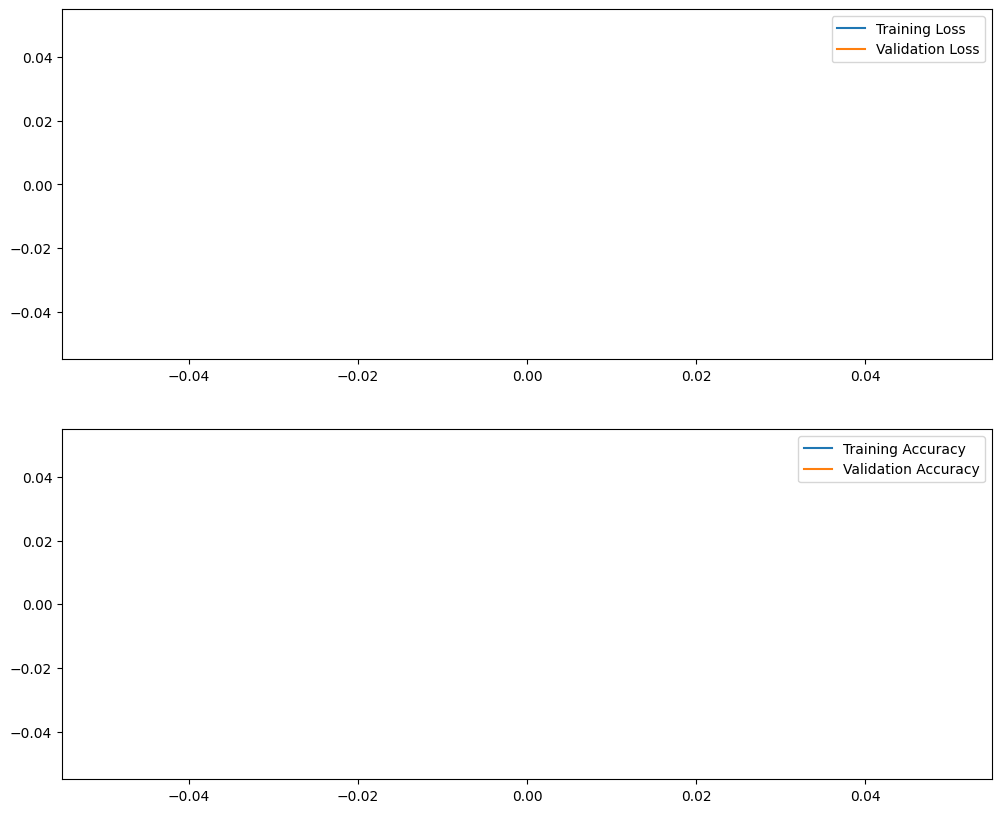

In [88]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(epoch_tr_loss, label='Training Loss')
ax1.plot(epoch_vl_loss, label='Validation Loss')
ax1.legend()
ax2.plot(epoch_tr_acc, label='Training Accuracy')
ax2.plot(epoch_vl_acc, label='Validation Accuracy')
ax2.legend()

plt.show()